Import some standard (numpy, matplotlib, and deepcopy) modules and the python library for STiC:

In [5]:
import sparsetools as sp
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from copy import deepcopy as cp

Define some functions to plot profiles, models and response functions:

In [6]:
def plot_profile(llp, t=0, y=0, x=0, s=0, kwargs=[], plkwargs={}):
    #
    #
    # Check inputs
    if (len(kwargs)!=len(llp)):
        ikwargs = [{},] * len(llp)
    else:
        ikwargs = cp(kwargs)
    #
    #
    ncols = len(llp[0].splitRegions())
    nrows = 1#np.ceil(npars/ncols).astype("i2")

    toadd_xlabel=1
    fg, ax = pl.subplots(ncols = ncols, nrows=nrows, sharey=1, **plkwargs)
    # Loop through profiles and plot kwargs
    labs = []
    for i,j in zip(llp, ikwargs):
        cnt=-1
        for k in i.splitRegions():
            cnt+=1
            ww = np.where(k.weights[:,s]<2)
            labs.append(ax.flat[cnt].plot(k.wav[ww[0]]-k.wav.mean(), k.dat[t,y,x,ww[0],s], **j))
            if (toadd_xlabel):
                ax.flat[cnt].set_xlabel(r"$\lambda-%.5f$" % (k.wav.mean(),))
        if (toadd_xlabel):
            toadd_xlabel=0
            
    #
    #
    # End plot:
    for i in ikwargs:
        if ("label" in i):
            lines_labels = [ax.flat[0].get_legend_handles_labels(),]
            lines, labels = [sum(i, []) for i in zip(*lines_labels)]
            fg.legend(lines, labels, loc="upper center", ncol=len(llp))
    fg.tight_layout()

In [7]:
def plot_model(llm, t=0, y=0, x=0, mpars=["temp", "vlos", "vturb", "Bln", "Bho", "azi"], kwargs=[], plkwargs={}, rfs=None):
    #
    #
    mnames = {"temp":"T", "vlos":r"v$_{\rm LOS}$", "vturb":r"v$_{\rm turb}$", "Bln":r"B$_{\parallel}$", "Bho":r"B$_{\perp}$", "azi":r"B$_{\phi}$"}
    munits = {"temp":"kK", "vlos":"km/s", "vturb":"km/s", "Bln":"G", "Bho":"G", "azi":"rd"}
    mfactors = {"temp":1.e-3, "vlos":1.e-5, "vturb":1.e-5, "Bln":1, "Bho":1, "azi":1}
    vmaxs = {"temp":12.5, "vlos":3, "vturb":5, "Bln":600, "Bho":1000, "azi":np.pi}
    vmins = {"temp":2.5, "vlos":-3, "vturb":0, "Bln":200, "Bho":0, "azi":0}

    dpar = {"temp":0, "vlos":1, "vturb":2, "Bln":3, "Bho":4, "azi":5}
    #
    # Check inputs
    if (len(kwargs)!=len(llm)):
        ikwargs = [{},] * len(llm)
    else:
        ikwargs = cp(kwargs)
    #
    plot_rf = False
    if (type(rfs)!=type(None)):
        assert type(rfs)==list
        assert len(rfs)==len(llm)
        plot_rf = True
    #
    npars = len(mpars)
    ncols = np.ceil(np.sqrt(npars)).astype("i2")
    nrows = np.ceil(npars/ncols).astype("i2")
    fg, ax = pl.subplots(ncols=ncols, nrows=nrows, sharex=True, **plkwargs)
    # Loop through model parameters and models and plot kwargs
    for lcp, lip in enumerate(mpars):
        cnt = -1
        for i,j in zip(llm, ikwargs):
            cnt+=1
            tmp = ax.flat[lcp].plot(i.ltau[t,y,x,:], getattr(i, lip)[t,y,x,:] * mfactors[lip], **j)
            if (plot_rf):
                if (type(rfs[cnt])!=type(None)):
                    #tadd = 1./np.abs(rfs[cnt].rf[t,y,x,dpar[lip],:,:,:]).sum((1,2))*np.sum(rfs[cnt].weights<1.e1)/600.
                    tadd = 1./np.abs(rfs[cnt].rf[t,y,x,dpar[lip],:,:,:]).sum((1,2))*10./600.

                    ax.flat[lcp].fill_between(i.ltau[t,y,x,:]
                                              , (getattr(i, lip)[t,y,x,:]-tadd) * mfactors[lip]
                                              , (getattr(i, lip)[t,y,x,:]+tadd) * mfactors[lip]
                                              , alpha=0.3, color=tmp[0].get_color())
    #
    #
    # End plot:
    for lcp, lip in enumerate(mpars):
        ax.flat[lcp].set_ylabel(r"%s [%s]" % (mnames[lip], munits[lip],))
        ax.flat[lcp].set_ylim(vmins[lip], vmaxs[lip])
    for i in ikwargs:
        if ("label" in i):
            pl.legend()
            break
    pl.tight_layout()

In [8]:
def plot_rf(llp, par, t=0, y=0, x=0, s=0, kwargs=[], plkwargs={}, yaxis=None):
    #
    #
    # Check inputs
    if (len(kwargs)!=len(llp)):
        ikwargs = [{},] * len(llp)
    else:
        ikwargs = cp(kwargs)
    #
    dpar = {"temp":0, "vlos":1, "vturb":2, "Bln":3, "Bho":4, "azi":5}
    #
    ncols = len(llp[0].splitRegions())
    nrows = len(llp)#np.ceil(npars/ncols).astype("i2")

    if (type(yaxis)==type(None)):
        ya = [0, llp[0].rf.shape[4]-1]
    else:
        ya = cp(yaxis)
    toadd_xlabel=1
    fg, ax = pl.subplots(ncols = ncols, nrows=nrows, sharey=1, **plkwargs)
    # Loop through profiles and plot kwargs
    for i,j in zip(llp, ikwargs):
        cnt=-1
        vmin, vmax = np.nanpercentile(i.rf[t,y,x,dpar[par],:,:,s].flatten(), [1,99])
        vval = np.max([np.abs([vmin, vmax])])
        vmin = -vval
        vmax = vval
        for k in i.splitRegions():
            cnt+=1
            xw = k.wav-k.wav.mean()
            ax.flat[cnt].imshow(k.rf[t,y,x,dpar[par],:,:,s], origin='lower', vmax=vmax, vmin=vmin, cmap="PuOr", interpolation="nearest", aspect="auto", extent=[xw[0],xw[-1],ya[0],ya[-1]])

            
            if (toadd_xlabel):
                ax.flat[cnt].set_xlabel(r"$\lambda-%.5f$" % (k.wav.mean(),))
        if (toadd_xlabel):
            toadd_xlabel=0
            
    #
    #
    # End plot:
    for i in ikwargs:
        if ("label" in i):
            fg.legend()
    fg.tight_layout()

Synthesize the Stokes spectra in 1D NLTE PRD of an MHD simulation (BIFROST, downloaded from [uio_site](https://sdc.uio.no/search/simulations)). It comes from the snapshot 463 of the enhanced network simulation ([Carlsson et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...585A...4C/abstract), [Gudiksen et al 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.154G/abstract)).

I have pre-selected a tiny FOV (field of view, with file name: "bifrost_model_small.nc") so that we can run the following part during the course. In addition we will use just one or two continuum points using an EOS (equation of state) in LTE (local thermodynamic equilibrium).

To do so, we have to edit/check:

    input.cfg
        mode, depth_t, atmosphere_type, input_model, output_profiles (= synthetic_cycle0.nc), output_atmos (= atmosout_cycle0.nc)



In [9]:
!ln -vfs input_synthesis_selectpixel.cfg input.cfg
!ln -vfs keyword_prd.input keyword.input

'input.cfg' -> 'input_synthesis_selectpixel.cfg'
'keyword.input' -> 'keyword_prd.input'


The following takes ~ 2 minutes.

In [3]:
!mpirun -n 3 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [10]:
obs = sp.profile("./synthetic_cycle0.nc")

profile::setsize: nx=46, ny=46, nw=1, ns=4, nt=1
['profiles' 'wav']
profile::read: [profiles][wav]


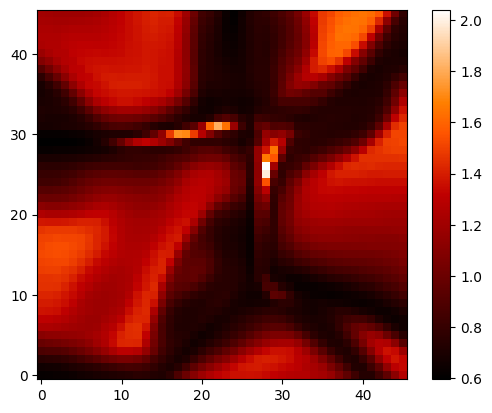

In [11]:
im=pl.imshow(obs.dat[0,:,:,0,0], origin='lower', cmap='gist_heat', interpolation='none')
cbar=pl.colorbar(im)


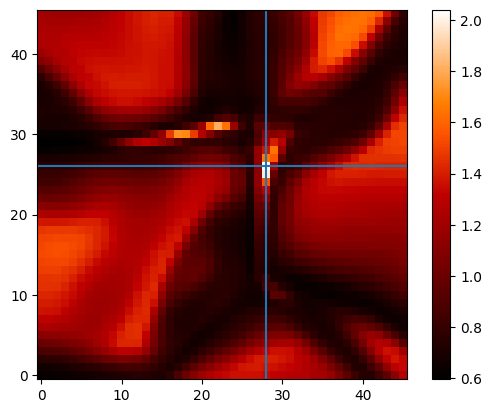

In [12]:
ix=28
iy=26
im=pl.imshow(obs.dat[0,:,:,0,0], origin='lower', cmap='gist_heat', interpolation='none')
cbar=pl.colorbar(im)
pl.axvline(ix)
pl.axhline(iy)

In [13]:
m = sp.model("./bifrost_model_small.nc")
m1d = m.extract(x0=ix,x1=ix+1,y0=iy,y1=iy+1)
m1d.write("inbifrost_model.nc")

model::read: atmos type -> depth-stratified
model::read: nx=46, ny=46, ndep=130, nt=1
model::setSize: nx = 46, ny = 46, ndep = 130, nt = 1
model::extract: x=(28,29), y=(26,27), z=(0,130), t=(0,1)
model::setSize: nx = 1, ny = 1, ndep = 130, nt = 1
model::write: inbifrost_model.nc -> nx=1, ny=1, ndep=130, nt=1



Now that we have selected our pixel, we will again use STiC to synthesis some spectra in PRD (when applicable) and 1D NLTE. While there are numerical codes that can solve the RT (radiative transfer) with more physics (see for example [MULTI3D](https://ui.adsabs.harvard.edu/abs/2009ASPC..415...87L/abstract) or [PORTA](https://ui.adsabs.harvard.edu/abs/2013A%26A...557A.143S/abstract) ) and even though this increased physics does have an impact in some of the lines we will use (see for example [Sukhorukov, Leenaarts 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A..46S/abstract) or [Bjørgen et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...611A..62B/abstract)), nowadays rutine NLTE inversions are only possible under a 1D approach.

To do so, we have to edit/check:

    input.cfg
        mode, depth_t, atmosphere_type, input_model (= inbifrost_model), output_profiles (= stk_inbifrost_model.nc), output_atmos (= atm_inbifrost_model.nc)
        # Regions information, they will be appended one after the other 
        region = 3932.19227,  0.03913,  76, 2.53705343e-05, fpi, 3934.nc
        region = 8540.23102,  0.04267,  88, 4.13985635e-05, fpi, 8542.nc
        region = 6301.24942,  0.01007,  46, 3.93137406e-05, fpi, 6302.nc
        region = 6302.12567,  0.01007,  49, 3.93159284e-05, fpi, 6302.nc

    keyword.input
    atoms.input


In [14]:
!ln -vfs keyword_prd.input keyword.input
!ln -vfs input_syn.cfg input.cfg

'keyword.input' -> 'keyword_prd.input'
'input.cfg' -> 'input_syn.cfg'


In [15]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [16]:
obs = sp.profile("./stk_inbifrost_model.nc")

profile::setsize: nx=1, ny=1, nw=259, ns=4, nt=1
['profiles' 'wav']
profile::read: [profiles][wav]


Plot them:

In [ ]:
plot_profile([obs,], s=0, plkwargs={"figsize":(11,6)})

We will simulate an observation with no polarimetry below 5000 angstrom and assuming we have achieved a SNR of 600:

In [ ]:
# Add some noise:
snr = 600.
nobs = cp(obs)
rng = np.random.default_rng(seed=12345)
nobs.dat += rng.normal(size=nobs.dat.size).reshape(*nobs.dat.shape) / snr
ww = np.where(nobs.wav < 5000.)
nobs.weights = nobs.weights * 0. + 1./snr
nobs.weights[ww[0],1:] = 1.e32
nobs.dat[:,:,:,ww[0],1:] *= 0

In [ ]:
plot_profile([obs,nobs],s=0, plkwargs={"figsize":(11,6)})

Write the modified synthetic spectra to use for the inversions:

In [ ]:
nobs.write("./observed.nc")

As we did in exercise 1, in order to run the Stokes inversion we need to provide an initial guess for the model atmosphere.

Generate a 'reasonable' model:

In [19]:
# Init the input model, all quantities in CGS units!
# First create a tau scale
taumin = -7.8
taumax= 1.0
dtau = 0.14
ntau = int((taumax-taumin)/dtau) + 1
tau = np.arange(ntau, dtype='float64')/(ntau-1.0) * (taumax-taumin) + taumin
# Now create a smooth temperature profile
temp = np.interp(tau, np.asarray([-8.0, -6.0, -4.0, -2.0 , 0.8]), np.asarray([70000., 8000., 4000., 4800., 7000.]))
# Fill in the model
m = sp.model(nx=1, ny=1, nt=1, ndep=ntau)
m.ltau[0,0,0,:] = tau
m.temp[0,0,0,:] = temp
# The inversion only needs to know the gas pressure at the upper boundary. FALC has Pgas[top] ~ 0.3, but
# this value is for quiet-Sun. Active regions can have up to Pgas[top] = 10.
m.pgas[0,0,0,:] = 1.0
# Fill in initial B field and velovity (optional)
m.vturb[0,0,0,:] = 1.e5
m.vlos[0,0,0,:] = 0.5e5 # cm/s
m.Bln[0,0,0,:] = 300.
m.Bho[0,0,0,:] = 650.
m.azi[0,0,0,:] = 100. * 3.14159 / 180.
# Write to HD
m.write('modelin.nc')


model::setSize: nx = 1, ny = 1, ndep = 63, nt = 1
model::write: modelin.nc -> nx=1, ny=1, ndep=63, nt=1


Consider the inversion of these "observations" considering PRD and NLTE inversion:

Check:

    input.cfg
    keyword.input
    atoms.input

In [20]:
!ln -vfs input_prd.cfg input.cfg
!ln -vfs keyword_prd.input keyword.input

'input.cfg' -> 'input_prd.cfg'
'keyword.input' -> 'keyword_prd.input'


The following one takes ~30 minutes!!

In [21]:
!mpirun -n 2 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

In [22]:
nlteprd_prof = sp.profile("./synthetic_cycle1_prd.nc")


profile::setsize: nx=1, ny=1, nw=259, ns=4, nt=1
['profiles' 'wav' 'weights' 'nodes_id' 'nodes_location' 'nodes_switch']
profile::read: [profiles][wav][weights]


Compare the synthetic profile of the inferred model (Stokes I -s=0-):

profile::setsize: nx=1, ny=1, nw=76, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=88, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=46, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=49, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=76, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=88, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=46, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=49, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=76, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=88, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=46, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=49, ns=4, nt=1


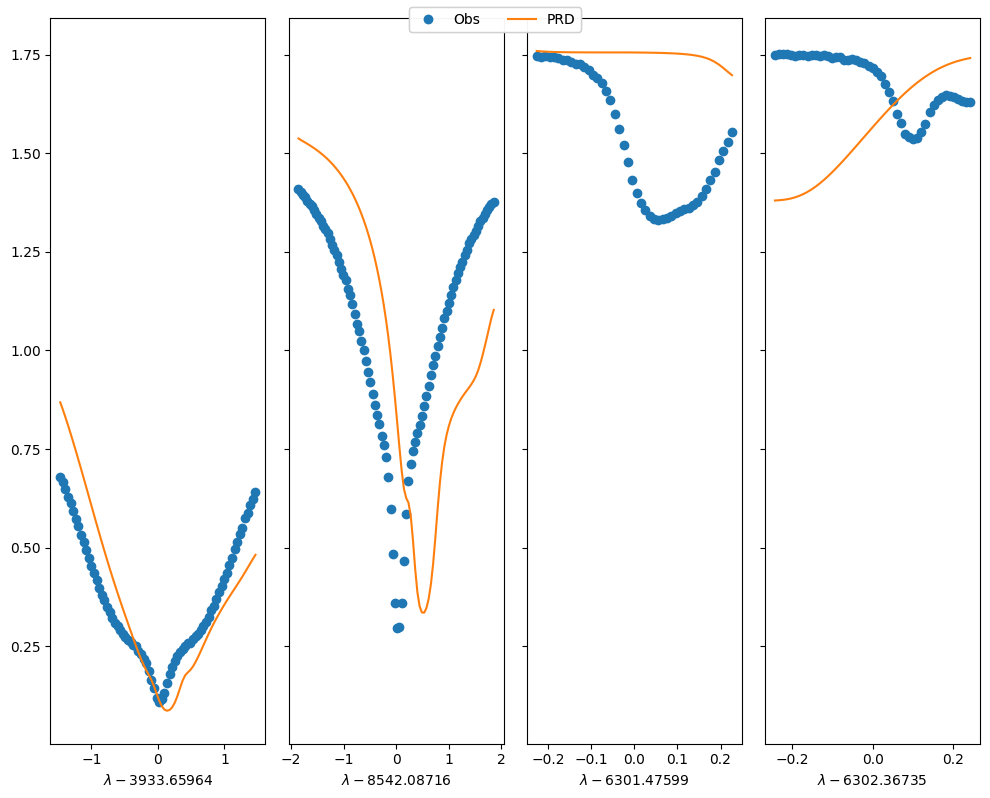

In [23]:
plot_profile([nobs,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"PRD"},]
             , plkwargs={"figsize":(10,8)})

Compare the synthetic profile of the inferred model (Stokes V -s=3-):

profile::setsize: nx=1, ny=1, nw=76, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=88, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=46, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=49, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=76, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=88, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=46, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=49, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=76, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=88, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=46, ns=4, nt=1
profile::setsize: nx=1, ny=1, nw=49, ns=4, nt=1


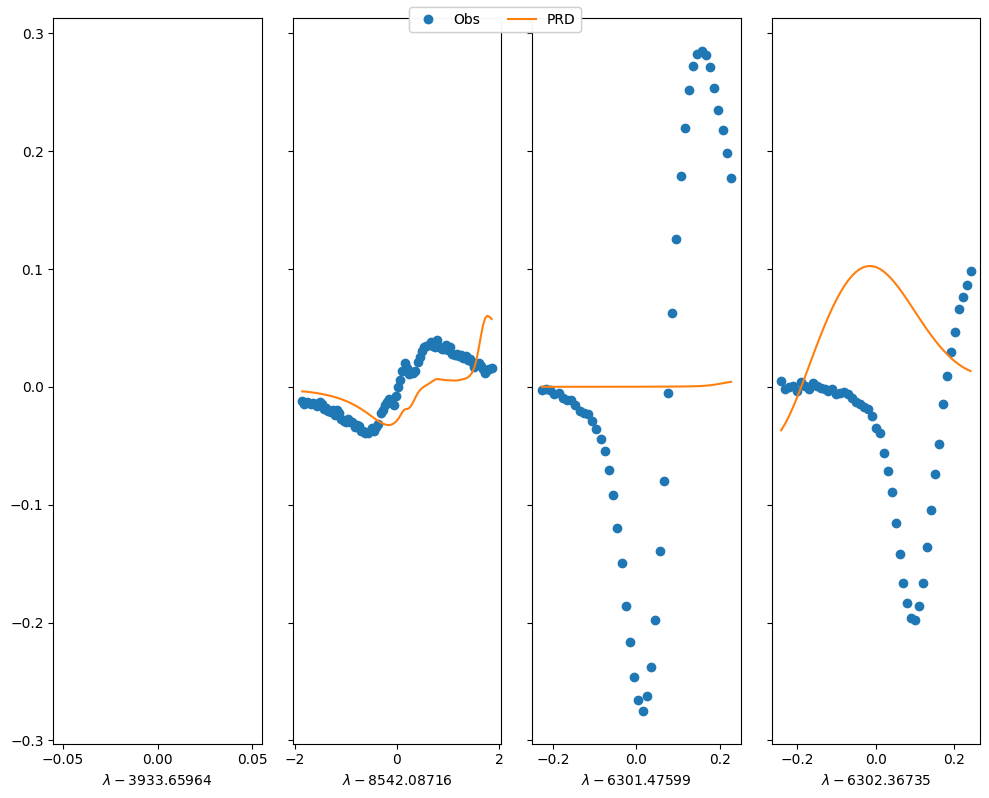

In [24]:
plot_profile([nobs,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"PRD"},]
             , plkwargs={"figsize":(10,8)}, s=3)

Compare the inferred model with the one we used to generate the "observations":

In [25]:
m_ref = sp.model("./atm_inbifrost_model.nc")
m_prd = sp.model("./atmosout_cycle1_prd.nc")

model::read: atmos type -> depth-stratified
model::read: nx=1, ny=1, ndep=130, nt=1
model::setSize: nx = 1, ny = 1, ndep = 130, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=1, ny=1, ndep=63, nt=1
model::setSize: nx = 1, ny = 1, ndep = 63, nt = 1


In [ ]:
plot_model([m_ref, m_prd]
           , kwargs=[{"label":"REF"},{"label":"PRD"}]
           , plkwargs={"figsize":(14,8)})

We can get an idea of the optical depths where the selected spectral lines provide us with information about the optical depth dependent model:

To do so, change the "mode" in "input.cfg" and add the following lane:

    #
    centered_derivatives = 1
    #              t, vlos, vturb, Bln, Bho, azi
    get_response = 1,    1,     1,   1,   1,   1


In [ ]:
!ln -vfs input_prd_rf.cfg input.cfg
!ln -vfs keyword_prd.input keyword.input

The following piece of code takes ~ minutes.

In [ ]:
!mpirun -n 2 ./STiC.x

Read the response functions. It is the same "profile" function as for the synthetic spectra but now there is an additional attribute called "rf".

In [ ]:
rfprd = sp.profile("synthetic_cycle1_prd_rf.nc")

Response functions encode how the Stokes spectra changes as a specific parameter varies at a given height.

For example, the response functions to the temperature are:

In [ ]:
plot_rf([rfprd,], "temp", yaxis=m_prd.ltau[0,0,0,:])


In [ ]:
plot_rf([rfprd,], "temp", yaxis=m_prd.ltau[0,0,0,:],s=3)


In [ ]:
plot_rf([rfprd,], "temp", yaxis=m_prd.ltau[0,0,0,:],s=1)


In [ ]:
plot_rf([rfprd,], "temp", yaxis=m_prd.ltau[0,0,0,:], s=2)

You can check the RFs for the "vlos", "vturb", "Bln", "Bho", and/or "azi"

We can now use the information of the response function to get a rough idea as to at what optical depths the spectra are sensitive to the model:

In [ ]:
plot_model([m_ref, m_prd,]
           , kwargs=[{"label":"REF"},{"label":"PRD"},]
           , plkwargs={"figsize":(14,8)}, rfs=[None, rfprd, ])

Exercises:

1-Repeat inversion in CRD:

    Hint: edit keyword.input so that "PRD_N_MAX_ITER=0"

2- Repeat inversion in LTE:

    Hint: edit input.cfg so that you get something like:

        # Type of atmosphere: rh or lte
        #atmosphere_type = rh
        atmosphere_type = lte
        lines = all

3- Change the number of nodes to get an idea of the impact they have in the inference

    Hint: you can change the number of nodes in "input.cfg":

        # nodes, it can be one number indicating the number of
        # equidistant nodes or the actual locations, coma-separated
        nodes_temp = 9
        nodes_vturb = 5
        nodes_vlos = 5
        nodes_blong = 3
        nodes_bhor = 2
        nodes_azi = 1


4- Change the regularization type/norm to check what the is the effect of regularization

    Hint: you can change the type and norm of the regularization in "input.cfg":

        # 0 none, 1 Tikhonov (first derivative), 2 deviations from mean, 3 deviations from zero
        # 7 numbers: Temp, Vlos, vturb, B, inc, azi, pgas_boundary
        # default (0,0,0,0,0,0,0). Not all numbers work with all parameters. For example deviations
        # from constant values for temperature does not make sense...in that case it reverts to zero
        # Regularization_weights: up to 7 numbers with the relative scaling of each parameter. This weight is multiplied by "regularize".

        regularization_type = 1,1,3,1,1,1,1
        regularize = 1
        regularization_weights = 1, 1, 1, 0.1, 0.1, 0.1, 1.0 

Message to take home:

    The results of the inference depend on the model one choses to explain the observations and the posterior analysis has to be done with that in mind!


In [ ]:
nobs.write("./observed.nc")

For the stokes inversion we need to provide an initial guess for the model atmosphere. Let us generate a 'reasonable' model:

In [ ]:
# Init the input model, all quantities in CGS units!
# First create a tau scale
taumin = -7.8
taumax= 1.0
dtau = 0.14
ntau = int((taumax-taumin)/dtau) + 1
tau = np.arange(ntau, dtype='float64')/(ntau-1.0) * (taumax-taumin) + taumin
# Now create a smooth temperature profile
temp = np.interp(tau, np.asarray([-8.0, -6.0, -4.0, -2.0 , 0.8]), np.asarray([70000., 8000., 4000., 4800., 7000.]))
# Fill in the model
m = sp.model(nx=1, ny=1, nt=1, ndep=ntau)
m.ltau[0,0,0,:] = tau
m.temp[0,0,0,:] = temp
# The inversion only needs to know the gas pressure at the upper boundary. FALC has Pgas[top] ~ 0.3, but
# this value is for quiet-Sun. Active regions can have up to Pgas[top] = 10.
m.pgas[0,0,0,:] = 1.0
# Fill in initial B field and velovity (optional)
m.vturb[0,0,0,:] = 1.e5
m.vlos[0,0,0,:] = 0.5e5 # cm/s
m.Bln[0,0,0,:] = 300.
m.Bho[0,0,0,:] = 650.
m.azi[0,0,0,:] = 100. * 3.14159 / 180.
# Write to HD
m.write('modelin.nc')


For reference, let us start with the inversion in LTE:

In [ ]:
!ln -vfs input_lte.cfg input.cfg

In [ ]:
!mpirun -n 2 ./STiC.x

Now, let us consider the case of a NLTE inversion but in CRD:

In [ ]:
!ln -vfs input_crd.cfg input.cfg

In [ ]:
!ln -vfs keyword_crd.input keyword.input

In [ ]:
!mpirun -n 2 ./STiC.x

Finally, let us consider the inversion of NLTE with PRD in a 1D approach, which is the model with the most physics that STiC can handle in the inversion

In [ ]:
!ln -vfs input_prd.cfg input.cfg

In [ ]:
!ln -vfs keyword_prd.input keyword.input

In [ ]:
!mpirun -n 2 ./STiC.x

In [ ]:
nlteprd_prof = sp.profile("./synthetic_cycle1_prd.nc")
nltecrd_prof = sp.profile("./synthetic_cycle1_crd.nc")
lte_prof = sp.profile("./synthetic_cycle1_lte.nc")


In [ ]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)})

In [ ]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)},s=3)

In [ ]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)},s=1)

In [ ]:
plot_profile([nobs,lte_prof,nltecrd_prof,nlteprd_prof]
             , kwargs=[{"label":"Obs","ls":"none","marker":"o"}, {"label":"LTE"}, {"label":"CRD"}, {"label":"PRD"},]
             , plkwargs={"figsize":(14,8)},s=2)

We can now compare the models we get in the various inversions to the reference one:

In [ ]:
m_ref = sp.model("./atm_inbifrost_model.nc")
m_lte = sp.model("./atmosout_cycle1_lte.nc")
m_crd = sp.model("./atmosout_cycle1_crd.nc")
m_prd = sp.model("./atmosout_cycle1_prd.nc")

In [ ]:
plot_model([m_ref, m_lte,m_crd, m_prd]
           , kwargs=[{"label":"REF"},{"label":"LTE"},{"label":"CRD"},{"label":"PRD"}]
           , plkwargs={"figsize":(14,8)})

However, the data we have used for the inversion does not necessarily probe the whole atmosphere we have included in the atmosphere model we feed the inversion with. One possibility to address this issue is to use the response functions (REFERENCES!!!), which can be calculated using STiC:

In [ ]:
!ln -vfs input_lte_rf.cfg input.cfg

In [ ]:
!mpirun -n 2 ./STiC.x

In [ ]:
!ln -vfs input_crd_rf.cfg input.cfg

In [ ]:
!ln -vfs keyword_crd.input keyword.input

In [ ]:
!mpirun -n 2 ./STiC.x

In [ ]:
!ln -vfs input_prd_rf.cfg input.cfg

In [ ]:
!ln -vfs keyword_prd.input keyword.input

In [ ]:
!mpirun -n 2 ./STiC.x

In [ ]:
tt = sp.profile("synthetic_cycle1_prd_rf.nc")

In [ ]:
pl.figure(figsize=(14,8))
im = pl.imshow(tt.rf[0,0,0,0,:,:,0], origin='lower', vmax=0.00005, cmap="Spectral", interpolation="none")
cbar = pl.colorbar(im)